In [1]:
import polars as pl
import geopandas as gpd
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.cluster as skc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
#from prophet import Prophet
#import pymc3 as pm
import pandas as pd
from scipy.integrate import odeint
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.decomposition import PCA
import dill as pickle
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, SplineTransformer, KernelCenterer, PolynomialFeatures, PowerTransformer, QuantileTransformer, Normalizer




In [12]:
test = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet').sort('end_date')
test

muni_id,temporal_sdm_both,start_date,end_date,temporal_sdm_albopictus,start_date_temporal_sdm_albopictus,temporal_sdm_aegypti,start_date_temporal_sdm_aegypti,EVI,start_date_EVI,total_evaporation_sum,start_date_total_evaporation_sum,total_precipitation_sum,start_date_total_precipitation_sum,evaporation_from_open_water_surfaces_excluding_oceans_min,start_date_evaporation_from_open_water_surfaces_excluding_oceans_min,soil_temperature_level_1,start_date_soil_temperature_level_1,runoff_sum,start_date_runoff_sum,surface_runoff_min,start_date_surface_runoff_min,volumetric_soil_water_layer_1,start_date_volumetric_soil_water_layer_1,dewpoint_temperature_2m,start_date_dewpoint_temperature_2m,temperature_2m,start_date_temperature_2m,total_precipitation_min,start_date_total_precipitation_min
i64,f64,date,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date
110001,0.293792,2000-12-03,2001-02-01,0.17041,2000-12-03,0.294167,2000-12-03,0.300041,2001-01-01,-0.004177,2001-01-01,0.007591,2001-01-01,-0.00079,2001-01-01,298.132139,2001-01-01,0.000449,2001-01-01,0.000167,2001-01-01,0.478415,2001-01-01,295.102645,2001-01-01,297.135084,2001-01-01,0.007591,2001-01-01
110002,0.128203,2000-12-03,2001-02-01,0.0658,2000-12-03,0.106721,2000-12-03,0.206216,2001-01-01,-0.003649,2001-01-01,0.00877,2001-01-01,-0.000166,2001-01-01,298.579709,2001-01-01,0.001364,2001-01-01,0.000375,2001-01-01,0.474644,2001-01-01,295.931828,2001-01-01,297.923434,2001-01-01,0.00877,2001-01-01
110003,0.134244,2000-12-03,2001-02-01,0.068927,2000-12-03,0.113906,2000-12-03,0.332168,2001-01-01,-0.004122,2001-01-01,0.004688,2001-01-01,-0.000113,2001-01-01,298.636869,2001-01-01,0.000164,2001-01-01,0.000082,2001-01-01,0.473723,2001-01-01,295.434372,2001-01-01,298.050497,2001-01-01,0.004688,2001-01-01
110004,0.181968,2000-12-03,2001-02-01,0.095157,2000-12-03,0.173059,2000-12-03,0.284917,2001-01-01,-0.004021,2001-01-01,0.00951,2001-01-01,-0.00042,2001-01-01,298.896741,2001-01-01,0.00075,2001-01-01,0.000544,2001-01-01,0.478906,2001-01-01,295.688685,2001-01-01,297.698716,2001-01-01,0.00951,2001-01-01
110005,0.153535,2000-12-03,2001-02-01,0.079188,2000-12-03,0.137468,2000-12-03,0.335107,2001-01-01,-0.004184,2001-01-01,0.004585,2001-01-01,-0.001023,2001-01-01,299.634662,2001-01-01,0.000263,2001-01-01,0.000102,2001-01-01,0.468664,2001-01-01,295.513438,2001-01-01,297.915813,2001-01-01,0.004585,2001-01-01
110006,0.303405,2000-12-03,2001-02-01,0.178009,2000-12-03,0.303653,2000-12-03,0.311076,2001-01-01,-0.004144,2001-01-01,0.005329,2001-01-01,-0.000249,2001-01-01,298.010673,2001-01-01,0.000139,2001-01-01,0.000091,2001-01-01,0.444659,2001-01-01,294.465309,2001-01-01,297.228094,2001-01-01,0.005329,2001-01-01
110007,0.197322,2000-12-03,2001-02-01,0.104244,2000-12-03,0.190829,2000-12-03,0.34465,2001-01-01,-0.004385,2001-01-01,0.005629,2001-01-01,-0.000614,2001-01-01,298.913301,2001-01-01,0.00018,2001-01-01,0.000114,2001-01-01,0.478198,2001-01-01,295.281912,2001-01-01,297.757088,2001-01-01,0.005629,2001-01-01
110008,0.100867,2000-12-03,2001-02-01,0.065587,2000-12-03,0.075642,2000-12-03,0.308424,2001-01-01,-0.004248,2001-01-01,0.005436,2001-01-01,-0.000099,2001-01-01,298.760897,2001-01-01,0.000189,2001-01-01,0.000121,2001-01-01,0.479754,2001-01-01,295.841965,2001-01-01,298.167543,2001-01-01,0.005436,2001-01-01
110009,0.247628,2000-12-03,2001-02-01,0.136621,2000-12-03,0.246882,2000-12-03,0.303083,2001-01-01,-0.003964,2001-01-01,0.009349,2001-01-01,-0.000571,2001-01-01,298.480588,2001-01-01,0.001253,2001-01-01,0.000488,2001-01-01,0.476768,2001-01-01,295.387108,2001-01-01,297.335723,2001-01-01,0.009349,2001-01-01


In [8]:
monthly_cases = pl.read_parquet('../data/cases/agged/dengue_per_month.parquet').with_columns(pl.col('DT_NOTIFIC').dt.offset_by('1mo').alias('end_date'))
monthly_params = pl.read_parquet('../data/gee_exports/all_parameters_2001-01-01_2021-01-01_months.parquet')
weekly_cases = pl.read_parquet('../data/cases/agged/dengue_per_week.parquet')
daily_cases = pl.read_parquet('../data/cases/agged/dengue_per_day.parquet')

In [10]:
#monthly_params.sort(['muni_id', 'end_date'])
monthly_cases = monthly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
})

In [13]:
monthly_cases.join(test, how='inner', on=['muni_id', 'end_date']).with_columns(pl.col('end_date').alias('month').dt.month())


muni_id,start_date,count,x_centroid,y_centroid,NM_MUN,pop,year,cases_per_100k,end_date,temporal_sdm_both,start_date_right,temporal_sdm_albopictus,start_date_temporal_sdm_albopictus,temporal_sdm_aegypti,start_date_temporal_sdm_aegypti,EVI,start_date_EVI,total_evaporation_sum,start_date_total_evaporation_sum,total_precipitation_sum,start_date_total_precipitation_sum,evaporation_from_open_water_surfaces_excluding_oceans_min,start_date_evaporation_from_open_water_surfaces_excluding_oceans_min,soil_temperature_level_1,start_date_soil_temperature_level_1,runoff_sum,start_date_runoff_sum,surface_runoff_min,start_date_surface_runoff_min,volumetric_soil_water_layer_1,start_date_volumetric_soil_water_layer_1,dewpoint_temperature_2m,start_date_dewpoint_temperature_2m,temperature_2m,start_date_temperature_2m,total_precipitation_min,start_date_total_precipitation_min,month
i64,date,u32,f64,f64,str,i64,str,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,f64,date,u32
261090,2001-01-01,4,6.9004e6,9.0303e6,"""Pesqueira""",57600,"""2001""",6.944444,2001-02-01,0.815822,2000-12-03,0.889802,2000-12-03,0.848074,2000-12-03,0.263019,2001-01-01,-0.000895,2001-01-01,0.000085,2001-01-01,-0.000351,2001-01-01,301.865679,2001-01-01,3.5763e-7,2001-01-01,3.4273e-7,2001-01-01,0.069654,2001-01-01,288.65525,2001-01-01,296.732309,2001-01-01,0.000085,2001-01-01,2
261160,2001-01-01,93,7.1010e6,9.0621e6,"""Recife""",1437190,"""2001""",6.470961,2001-02-01,0.147099,2000-12-03,0.079524,2000-12-03,0.124176,2000-12-03,0.206202,2001-01-01,-0.002609,2001-01-01,0.000917,2001-01-01,-0.001167,2001-01-01,301.231897,2001-01-01,0.000095,2001-01-01,0.000007,2001-01-01,0.243936,2001-01-01,293.678382,2001-01-01,299.746231,2001-01-01,0.000917,2001-01-01,2
221140,2001-01-01,14,6.3021e6,9.2600e6,"""Várzea Grande""",4480,"""2001""",312.5,2001-02-01,0.304474,2000-12-03,0.113402,2000-12-03,0.27118,2000-12-03,0.361755,2001-01-01,-0.003763,2001-01-01,0.003502,2001-01-01,-0.000998,2001-01-01,299.873278,2001-01-01,0.000029,2001-01-01,0.000026,2001-01-01,0.33123,2001-01-01,294.040172,2001-01-01,298.064608,2001-01-01,0.003502,2001-01-01,2
330250,2001-01-01,48,6.1183e6,7.4575e6,"""Magé""",210861,"""2001""",22.763811,2001-02-01,0.397118,2000-12-03,0.38288,2000-12-03,0.360123,2000-12-03,0.362983,2001-01-01,-0.005113,2001-01-01,0.003515,2001-01-01,-0.000491,2001-01-01,300.473692,2001-01-01,0.000505,2001-01-01,0.000063,2001-01-01,0.381232,2001-01-01,294.807948,2001-01-01,299.037432,2001-01-01,0.003515,2001-01-01,2
312770,2001-01-01,1747,6.2680e6,7.8794e6,"""Governador Val…",248960,"""2001""",701.719152,2001-02-01,0.10519,2000-12-03,0.042876,2000-12-03,0.083847,2000-12-03,0.276075,2001-01-01,-0.004198,2001-01-01,0.000386,2001-01-01,-0.000926,2001-01-01,299.908398,2001-01-01,0.000441,2001-01-01,0.000005,2001-01-01,0.360168,2001-01-01,292.610876,2001-01-01,298.945548,2001-01-01,0.000386,2001-01-01,2
313580,2001-01-01,50,6.3789e6,8.1435e6,"""Jequitinhonha""",22869,"""2001""",218.636582,2001-02-01,0.454964,2000-12-03,0.336327,2000-12-03,0.432499,2000-12-03,0.446538,2001-01-01,-0.002907,2001-01-01,0.000233,2001-01-01,-0.000221,2001-01-01,298.074134,2001-01-01,0.000006,2001-01-01,0.000005,2001-01-01,0.246051,2001-01-01,290.895849,2001-01-01,297.171467,2001-01-01,0.000233,2001-01-01,2
171610,2001-01-01,444,5.5667e6,8.8655e6,"""Paraíso do Toc…",37141,"""2001""",1195.444388,2001-02-01,0.247628,2000-12-03,0.136621,2000-12-03,0.246882,2000-12-03,0.276841,2001-01-01,-0.003866,2001-01-01,0.00633,2001-01-01,-0.00057,2001-01-01,299.48356,2001-01-01,0.002074,2001-01-01,0.000382,2001-01-01,0.444521,2001-01-01,294.603184,2001-01-01,297.764315,2001-01-01,0.00633,2001-01-01,2
170210,2001-01-01,150,5.5976e6,9.1857e6,"""Araguaína""",115901,"""2001""",129.420799,2001-02-01,0.189552,2000-12-03,0.099603,2000-12-03,0.181836,2000-12-03,0.198832,2001-01-01,-0.003844,2001-01-01,0.007471,2001-01-01,-0.001107,2001-01-01,299.693874,2001-01-01,0.000536,2

: 

In [ ]:
#TODO: something going wrong with the join on this one
#monthly_params = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')

In [3]:
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp').astype({'CD_MUN': 'string'})

In [4]:
munis['CD_MUN'] = munis['CD_MUN'].str.slice(stop=-1).astype(int)

In [ ]:
munis[munis['CD_MUN']==251315] 

In [14]:
monthly_params = monthly_params.with_columns((pl.col('start_date').str.to_date('%Y-%m-%d'),pl.col('end_date').str.to_date('%Y-%m-%d')))

In [ ]:
weekly_cases = weekly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
}).with_columns(pl.col('start_date').alias('month').dt.month())

In [ ]:
daily_cases = daily_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
})

In [16]:
all_data = monthly_cases.join(monthly_params, how='left', on=['muni_id', 'start_date']).with_columns(pl.col('end_date').alias('month').dt.month())


In [ ]:
#data = monthly_cases.group_by(pl.col('start_date')).agg((pl.col('count').sum(), pl.col('pop').sum())).to_pandas()

data = all_data.select(['muni_id', 'cases_per_100k', 'start_date', ]).to_pandas()

In [ ]:
pivot_df = data.pivot(index = 'start_date', columns='muni_id', values='cases_per_100k')

In [ ]:
np.corrcoef(all_data.select(['muni_id', 'cases_per_100k', 'start_date']).pivot(index = 'muni_id', columns='start_date', values='cases_per_100k'))[0]

In [ ]:
corr_matrix = pivot_df.corr()

In [ ]:
np.nanmean(np.triu(corr_matrix.to_numpy(), k=1))

In [ ]:
#412050 is least helped by adding neighbors
corr_matrix.loc[352115].sort_values().nlargest(10)

In [ ]:
corr_abs = corr_matrix #.abs()

# Create an empty matrix to store the results
top_correlated_matrix = pd.DataFrame(index=corr_abs.index, columns=range(1, 10))

# Loop through each row in the correlation matrix
for idx, row in corr_abs.iterrows():
    # Sort the correlations in descending order and get the top 20
    top_correlated = row.sort_values(ascending=False)[1:10]
    
    # Assign the top correlated items to the respective row in the result matrix
    top_correlated_matrix.loc[idx] = top_correlated.index

# Print the top correlated matrix
#print(top_correlated_matrix)
top_correlated_matrix.loc[[431870,]]

In [ ]:
proj_mun = munis.to_crs('EPSG:29101')

In [ ]:
coordinates_df = pd.DataFrame(index=proj_mun['CD_MUN'])
coordinates_df['x_coordinate'] = proj_mun.geometry.centroid.x.to_numpy()
coordinates_df['y_coordinate'] = proj_mun.geometry.centroid.y.to_numpy()

In [ ]:
combined_df = pd.merge(top_correlated_matrix, coordinates_df, left_index=True, right_index=True)
combined_df

In [ ]:
from shapely import Point, LineString
# Define a function to compute the distance between coordinates
def compute_distance(row, original_x, original_y):
    return ((row['x_coordinate'] - original_x) ** 2 + (row['y_coordinate'] - original_y) ** 2) ** 0.5


ids = []
geos = []

for i in range(0, len(combined_df)):
    matches = coordinates_df.loc[combined_df.iloc[i][0:9]]
    x, y = combined_df.iloc[i]['x_coordinate'], combined_df.iloc[i]['y_coordinate']
    matches['distance'] = ((matches['x_coordinate']- x) ** 2 + (matches['y_coordinate'] - y) ** 2) ** 0.5
    matches = matches.sort_values('distance')
    geo = LineString([Point(x,y)]+[Point(x_,y_) for x_, y_ in zip(matches['x_coordinate'], matches['y_coordinate'])])
    geos.append(geo)
    ids.append(combined_df.index[i])

combined_df.iloc[i]

In [ ]:
gdf = gpd.GeoDataFrame(index=ids, data=ids, geometry=geos, crs='EPSG:29101').to_crs('EPSG:4326')
gdf_ = gpd.GeoDataFrame(index=ids, data=ids, geometry=geos, crs='EPSG:29101')
lengths = []
for row in gdf_.iterfeatures():

    first = row['geometry']['coordinates'][0]
    last = row['geometry']['coordinates'][-1]

    distance = ((first[0] - last[0]) ** 2 + (first[1]-last[1]) ** 2) ** 0.5
    lengths.append(distance/1000)
lengths = np.array(lengths)
print(lengths.mean())
print(lengths.min())
print(lengths.max())

In [ ]:
import leafmap.foliumap as leafmap
m = leafmap.Map(center=(40, -100), zoom=3)
#TODO: SEARCH FOR OVERLAPPING LINE SEGMENTS
id = 251315                      #   412050
m.add_gdf(gdf.iloc[np.random.choice(list(range(0,5500)), size=10)])



# m.add_gdf(gdf.loc[[id,]])
# first = gdf.loc[[id,]].geometry.item().coords[0]
# m.add_gdf(gpd.GeoDataFrame(data=[id], geometry=[Point(first)], crs='EPSG:4326'))

m

Each row:
Target: This months cases per 100k
Features: 
    This months environmental variables
    Previous 24 months environmental variables
    Previous 24 months case history
    Previous 12 months case history for 10 most related munis

In [250]:
def make_simple_binary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([300], labels=['0','1']).alias('cat_target'))

In [251]:
def make_simple_ternary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([100,300], labels=['0','1', '2']).alias('cat_target'))

In [ ]:
def train_and_test_reg(train, test):
    reg = HistGradientBoostingRegressor(
    random_state=42,
    categorical_features = [train['X'].shape[1]-1], 
    loss='poisson', 
    max_iter=5000, 
    max_leaf_nodes=None, 
    min_samples_leaf=10,
    l2_regularization=2.0, 
    max_bins=255,
    early_stopping=False)
    reg.fit(train['X'], train['y'])
    z =reg.predict(test['X'])

    return {
        'reg': reg,
        'predictions': z,
        'test_data': test['y'],
        'score': reg.score(test['X'], test['y']),
        'rmse': np.sqrt(((z - test['y']) ** 2).mean())
    }

In [266]:
from itertools import chain
import math
def create_data_dict(start_date, 
                    end_date, 
                    all_data: pl.DataFrame, 
                    target_var = 'cases_per_100k',
                    case_lookback=24,
                    case_lag=1,
                    env_lag=0, 
                    env_lookback = 12,
                    env_list = [
                    'total_precipitation_sum', 
                    'temperature_2m', 
                    ],
                    additional_features = ['month', 'pop']
                    ):
    return (
        all_data
        .select(['muni_id', 'start_date', target_var] + env_list + additional_features)
        .filter((pl.col('start_date')>=datetime.fromisoformat(start_date)-relativedelta(years=math.ceil(case_lookback/12))) & (pl.col('start_date')<datetime.fromisoformat(end_date)))
        .with_columns(
            list(
                chain.from_iterable(
                    [
                        [pl.col(target_var).shift(i).over('muni_id').alias(f'{i}_shifted_cases')] for i in range(case_lag,case_lookback+case_lag)
                    ]
                    +
                    
                    [
                        [pl.col(e_var).shift(i).over('muni_id').alias(f'{i}_shifted_{e_var}') for i in range(env_lag,env_lookback+env_lag)] 
                            for e_var in env_list
                    ]
                    )
                )
        )
        .drop_nulls()
        .select(pl.exclude(env_list))
        .rename({target_var: 'target'})
        .partition_by('muni_id', as_dict=True)
    )

fdf = create_data_dict('2001-01-01', '2020-12-01', all_data)

fdf

{261090: shape: (215, 53)
 ┌─────────┬────────────┬────────────┬───────┬───┬────────────┬────────────┬────────────┬───────────┐
 │ muni_id ┆ start_date ┆ target     ┆ month ┆ … ┆ 8_shifted_ ┆ 9_shifted_ ┆ 10_shifted ┆ 11_shifte │
 │ ---     ┆ ---        ┆ ---        ┆ ---   ┆   ┆ temperatur ┆ temperatur ┆ _temperatu ┆ d_tempera │
 │ i64     ┆ date       ┆ f64        ┆ u32   ┆   ┆ e_2m       ┆ e_2m       ┆ re_2m      ┆ ture_2m   │
 │         ┆            ┆            ┆       ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
 │         ┆            ┆            ┆       ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
 ╞═════════╪════════════╪════════════╪═══════╪═══╪════════════╪════════════╪════════════╪═══════════╡
 │ 261090  ┆ 2003-01-01 ┆ 1.731572   ┆ 2     ┆ … ┆ 295.790449 ┆ 296.520078 ┆ 296.954635 ┆ 296.87433 │
 │         ┆            ┆            ┆       ┆   ┆            ┆            ┆            ┆ 1         │
 │ 261090  ┆ 2003-02-01 ┆ 96.968018  ┆ 3     ┆ … ┆ 293.9

In [270]:
def get_features_for_muni(df, cat_fn=None, check_zeros=False):
    if check_zeros:
        if df.select(pl.col('target')).to_series().sum() == 0:
            return None
    selected = df if cat_fn is None else cat_fn(df)
    target_key = 'target' if cat_fn is None else 'cat_target'
    target = selected.select(pl.col(target_key)).to_series().to_numpy().astype(float) 

    features = selected.select(pl.exclude(['muni_id', 'start_date', 'target', 'count', 'cat_target'])).to_numpy()
    dates = selected.select(pl.col('start_date')).to_series()
    muni_id = selected.select(pl.col('muni_id').first()).item()

    return {'X': features,
            'y': target,
            'dates': dates,
            'muni_id': muni_id}

f = get_features_for_muni(fdf[261090])['X']
f[:,0]


array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,
        3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,
        5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,
        6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,
        7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
        9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
       10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,
        2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,
        3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2

In [275]:
def train_and_test_clas(train, test, cat_style=''):

    #n_components = 15
    n_components = train['X'].shape[1]
    
    reg = HistGradientBoostingClassifier(
    random_state=42,
    categorical_features = [0],
    #l2_regularization=.05,
    #categorical_features=[15],
    max_iter=5000, 
    #learning_rate=0.5,
    #max_leaf_nodes=None, 
    #min_samples_leaf=10,
    #max_bins=255,
    early_stopping=True,
    class_weight='balanced',
    )

    ct = ColumnTransformer([
        #('min_max', MinMaxScaler(), list(range(0, n_components-1))),
        ('min_max', RobustScaler(), list(range(1, n_components))),
    ],
    remainder='passthrough')

    train_x = ct.fit_transform(train['X'])
    test_x = ct.transform(test['X'])

    #sample_weight = compute_sample_weight('balanced', train['y'])
    reg.fit(train_x, train['y'], 
            #sample_weight=sample_weight
            )
    z =reg.predict(test_x)

    return pl.DataFrame({
        'predictions': z,
        'ground_truth': test['y'],
        'date': test['dates'],
        'muni_id': [test['muni_id']]*len(z),
        'cat_style': [cat_style]*len(z)
    })

In [171]:
def handle_zero_case(muni_id):
    return pl.DataFrame({
        'predictions': [-999.0],
        'ground_truth': [-999.0],
        'date': [datetime.fromisoformat('1900-01-01')],
        'muni_id': [muni_id],
        'cat_style': ['NA']
    })

In [168]:
def write_results(df: pl.DataFrame, save_dir, save_prefix, muni_id):
    #muni_id = df.select('muni_id').head(n=1).item()
    df.write_csv(os.path.join(save_dir, f'{muni_id}_{save_prefix}.csv'))


In [282]:
TRAIN_START = '2005-01-01'
TRAIN_END = '2018-01-01'

TEST_START = '2018-01-01'
TEST_END = '2020-01-01'

EL = 12
LC = 24
UN = False
ALL_DATA = all_data
SAVE_DIR = '/home/tony/dengue/dengue_models/results/ternary'
SAVE_PREFIX = 'simple_ternary'
CAT_STYLE = 'simple_ternary'
CAT_FN = make_simple_ternary
completed_munis = []
def train_models():
    all_results = []

    train_dict = create_data_dict(TRAIN_START, TRAIN_END, ALL_DATA, env_list=[])
    test_dict = create_data_dict(TEST_START, TEST_END, ALL_DATA, env_list=[])

    for k, v in tqdm(train_dict.items()):
        train_data = get_features_for_muni(v, CAT_FN, check_zeros=True)
        if train_data is None:
            results = handle_zero_case(k)
            all_results.append(results)
            write_results(results, SAVE_DIR, SAVE_PREFIX, k)
            continue

        test_data = get_features_for_muni(test_dict[k], CAT_FN, check_zeros=False)
    #Train Classifier
    #Test classifier
    #Log results to dataframe
        try:
            results = train_and_test_clas(train_data, test_data, cat_style=CAT_STYLE)
        except BaseException as e:
            print(e)
            results = pl.DataFrame({
        'predictions': [-999.0],
        'ground_truth': [-999.0],
        'date': [datetime.fromisoformat('1900-01-01')],
        'muni_id': [k],
        'cat_style': ['NA']
        })
        all_results.append(results)
        #Save individual dataframe
        write_results(results, SAVE_DIR, SAVE_PREFIX, k)
        completed_munis.append(k)
    return all_results
    

In [283]:

all_results = train_models()
all_results_df = pl.concat(all_results)
all_results_df.write_csv(os.path.join(SAVE_DIR, f'{SAVE_PREFIX}_all_results.csv'))

  0%|          | 0/5570 [00:00<?, ?it/s]

The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
The least populated class in y has only 1 member, which is too

TODO:
    Test binary classifier (over under 300)
    Test ternary classifier (300/1000 splits) -- look up paper
    test ternary classifier - historic


As I mentioned, I've been absent from the last two calls and perhaps I will be repetitive. But my suggestion is to define the thresholds ourselves. And we need to consider that dengue is seasonal but the municipality's seasonality is not synchronous throughout the country. The intensity of transmission also varies among areas due to urban infrastructure, climate, mosquito traits variation among populations, etc. Since we are looking at a dengue time series of ~20 years, what do you think about using historical data and setting the threshold based on an expectation for that period?  For example, if based on historical data, we expect 1000 cases in one month for one Municipality. If that year's time series suggests up to 10% of the historical estimates, we would have a low risk. If 10-30% moderate. If 30-50% high. If >50% extremely high. Then we could have specific recommendations based on each situation.

In [10]:
def set_expectations(df: pl.DataFrame):

    expected = (
        df
        .group_by(['muni_id', 'month'])
        .agg(pl.col('cases_per_100k').median())
        .with_columns(
            [
                (pl.col('cases_per_100k') * pl.lit(.10)).alias('low_max'),
                (pl.col('cases_per_100k') * pl.lit(.30)).alias('moderate_max'),
                (pl.col('cases_per_100k') * pl.lit(.50)).alias('high_max')

            ]
        )
    )

In [54]:
(
    all_data
    #.filter(pl.col('count')!= 0)
    .with_columns(
        pl.col('count')
        .rank(method='ordinal')
        .over(['muni_id', 'month'])
        .qcut([.1,.3,.5], labels=['low', 'medium', 'high', 'very_high'])

        .alias('qcut')
        )
    .select(['muni_id', 'start_date', 'cases_per_100k', 'qcut', 'month'])
    .filter((pl.col('muni_id')==261090)&(pl.col('month')==11))
)

muni_id,start_date,cases_per_100k,qcut,month
i64,date,f64,cat,u32
261090,2001-10-01,15.625,"""very_high""",11
261090,2002-10-01,0.0,"""low""",11
261090,2003-10-01,10.38943,"""very_high""",11
261090,2004-10-01,1.730942,"""medium""",11
261090,2005-10-01,10.383677,"""very_high""",11
261090,2006-10-01,1.730283,"""medium""",11
261090,2007-10-01,54.244198,"""very_high""",11
261090,2008-10-01,3.130968,"""high""",11
261090,2009-10-01,7.75747,"""very_high""",11


In [ ]:
el = 1
lc = 2
nc = 1
results_dict = {}
for muni in tqdm(test_munis):
    train_data = assemble_data(muni,'2010-01-01', '2018-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=True)
    if train_data['y'].sum() == 0:
        continue
    test_data = assemble_data(muni,'2018-01-01', '2020-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=True)
    neighbor_results = train_and_test_reg(train_data, test_data)

    train_data = assemble_data(muni,'2010-01-01', '2018-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=False)
    if train_data['y'].sum() == 0:
        continue
    test_data = assemble_data(muni,'2018-01-01', '2020-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=False)
    no_neighbor_results = train_and_test_reg(train_data, test_data)

    results_dict[muni] = {
        'neighbors': neighbor_results,
        'no_neighbors': no_neighbor_results,
        'neighbor_rmse': neighbor_results['rmse'],
        'no_neighbor_rmse': no_neighbor_results['rmse']
    }
    


In [ ]:
el = 1
lc = 2
nc = 1
results_dict = {}
for muni in tqdm(test_munis):
    train_data = assemble_data(muni,'2010-01-01', '2018-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=True)
    if train_data['y'].sum() == 0:
        continue
    test_data = assemble_data(muni,'2018-01-01', '2020-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=True)
    neighbor_results = train_and_test_reg(train_data, test_data)

    train_data = assemble_data(muni,'2010-01-01', '2018-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=False)
    if train_data['y'].sum() == 0:
        continue
    test_data = assemble_data(muni,'2018-01-01', '2020-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=False)
    no_neighbor_results = train_and_test_reg(train_data, test_data)

    results_dict[muni] = {
        'neighbors': neighbor_results,
        'no_neighbors': no_neighbor_results,
        'neighbor_rmse': neighbor_results['rmse'],
        'no_neighbor_rmse': no_neighbor_results['rmse']
    }
    


In [183]:
def assemble_data(muni_id, start_date, end_date, all_data, env_lookback=1, local_case_lookback=2, neighbor_case_lookback=1, use_neighbors=True, cat_fn=None, check_zeros=True):
    targets = []
    cat_targets = []
    features = []
    muni_ids = []
    dates = []

    start_date = datetime.fromisoformat(start_date)
    end_date = datetime.fromisoformat(end_date)
    i=muni_id

    if cat_fn is not None:
        all_data = cat_fn(all_data)

    for j in all_data.select('start_date').filter((pl.col('start_date')>=start_date) & (pl.col('start_date')<end_date)).unique().to_series():
        

        this_data = all_data.filter(pl.col('muni_id')==i)

        single_entry = this_data.filter(pl.col('start_date') == j)
        target = single_entry.select('cases_per_100k').item()
        target_month = single_entry.select('month').to_numpy()
        cat_target = single_entry.select('cat_target').item()

        env_list = [
                    'total_precipitation_sum', 
                    'temperature_2m', 
                    ]

        #env_table = this_data.select(['start_date'] + env_list)

        #env_vars = env_table.filter((pl.col('start_date')<=j) & (pl.col('start_date')>j-relativedelta(years=env_lookback))).select(env_list).unstack(step=1).to_numpy()
        local_cases = this_data.filter((pl.col('start_date')<j) & (pl.col('start_date')>=j-relativedelta(years=local_case_lookback))).select('cases_per_100k').unstack(step=1).to_numpy()
        #local_means =  this_data.filter((pl.col('start_date')<j) & (pl.col('start_date')>=j-relativedelta(years=1))).select(pl.col('cases_per_100k').ewm_mean(com=1)).drop_nulls().unstack(step=1).to_numpy()        
        to_stack = [
            local_cases,
            #local_means,
            #env_vars,
            target_month
        ]

        # if use_neighbors:
        #     neighbors = top_correlated_matrix.loc[i]
        #     neighbors_cases = (all_data
        #                        .filter((pl.col('muni_id').is_in(neighbors)) & (pl.col('start_date')<j) & (pl.col('start_date')>=j-relativedelta(years=neighbor_case_lookback)))
        #                        .select(pl.col('cases_per_100k')).drop_nulls()
        #                        .unstack(step=1)
        #                        .to_numpy()
        #     )
        #     to_stack = [neighbors_cases] + to_stack
        feature = np.squeeze(
                np.hstack(
                    to_stack
            )
        )

        targets.append(target)
        cat_targets.append(cat_target)
        features.append(feature)
        muni_ids.append(i)
        dates.append(j)
    if check_zeros:
        if np.array(targets).sum() == 0:
            return None
    y = np.array(targets) if cat_fn is None else np.array(cat_targets).astype(float)
    X = np.vstack(features)

    return {
        'X': X,
        'y': y,
        'muni_id': i,
        'dates': dates
    }


In [ ]:
ids = []
neighbors_rmse = []
no_neighbors_rmse = []

for k, v in results_dict.items():
    ids.append(k)
    neighbors_rmse.append(v['neighbor_rmse'])
    no_neighbors_rmse.append(v['no_neighbor_rmse'])

results_df = pd.DataFrame(index=ids, data={'neighbors_rmse': neighbors_rmse, 'no_neighbors_rmse': no_neighbors_rmse, 'muni_id': ids})
results_df['neighbor_improvement'] = results_df['no_neighbors_rmse'] - results_df['neighbors_rmse']

results_df.sort_values('neighbor_improvement', ascending=False)

In [ ]:
plt.scatter(results_dict[312380]['no_neighbors']['test_data'],results_dict[312380]['no_neighbors']['predictions'])

In [ ]:
(results_df['neighbor_improvement']>0).sum()

In [ ]:
results_gdf = munis.merge(results_df, left_on='CD_MUN', right_on='muni_id')

In [ ]:
ax= munis.plot(figsize=(10,10))
results_gdf.plot(ax=ax, column=results_gdf['neighbor_improvement'], cmap='seismic', legend=True, vmin=-200, vmax=200)
#Can check relationship with population

In [ ]:
import leafmap.foliumap as leafmap
import leafmap.colormaps as cm
m = leafmap.Map(center=(40, -100), zoom=3)
#TODO: SEARCH FOR OVERLAPPING LINE SEGMENTS
id = 412050
#m.add_gdf(gdf.iloc[np.random.choice(list(range(0,5500)), size=10)])
#m.add_gdf(gdf.loc[[431870,]])
m.add_data(results_gdf, column='neighbor_improvement', cmap='seismic', scheme='EqualInterval')
m

In [ ]:
test_muni = all_data.filter(pl.col('muni_id') == 530010)

In [118]:
cluster_features = ['cases_per_100k', 
                     #'temperature_2m', 
                     #'total_precipitation_min', 
                    # 'EVI'
                    ]
case_data = (
                all_data
                #weekly_cases
               .select(pl.col(['end_date', 'muni_id',  'month'] + cluster_features))
               .filter(
                    (pl.col('end_date') >= datetime(2010,1,1)) &
                    (pl.col('end_date') < datetime(2019,1,1)) &
                    (pl.col('month').is_in([11, 12, 1, 2, 3, 4, 5]))
                    )
               .sort('end_date')
               .group_by('muni_id', maintain_order=True)
               .agg([pl.col(f) for f in cluster_features])
               .sort('muni_id')
               )
case_matrix = np.vstack(
               case_data
               .select(pl.concat_list(cluster_features))
               .to_series())
muni_matrix = np.vstack(
               case_data.select(pl.col('muni_id'))
               .to_series()
               )
muni_matrix

array([[110001],
       [110002],
       [110003],
       ...,
       [522220],
       [522230],
       [530010]])

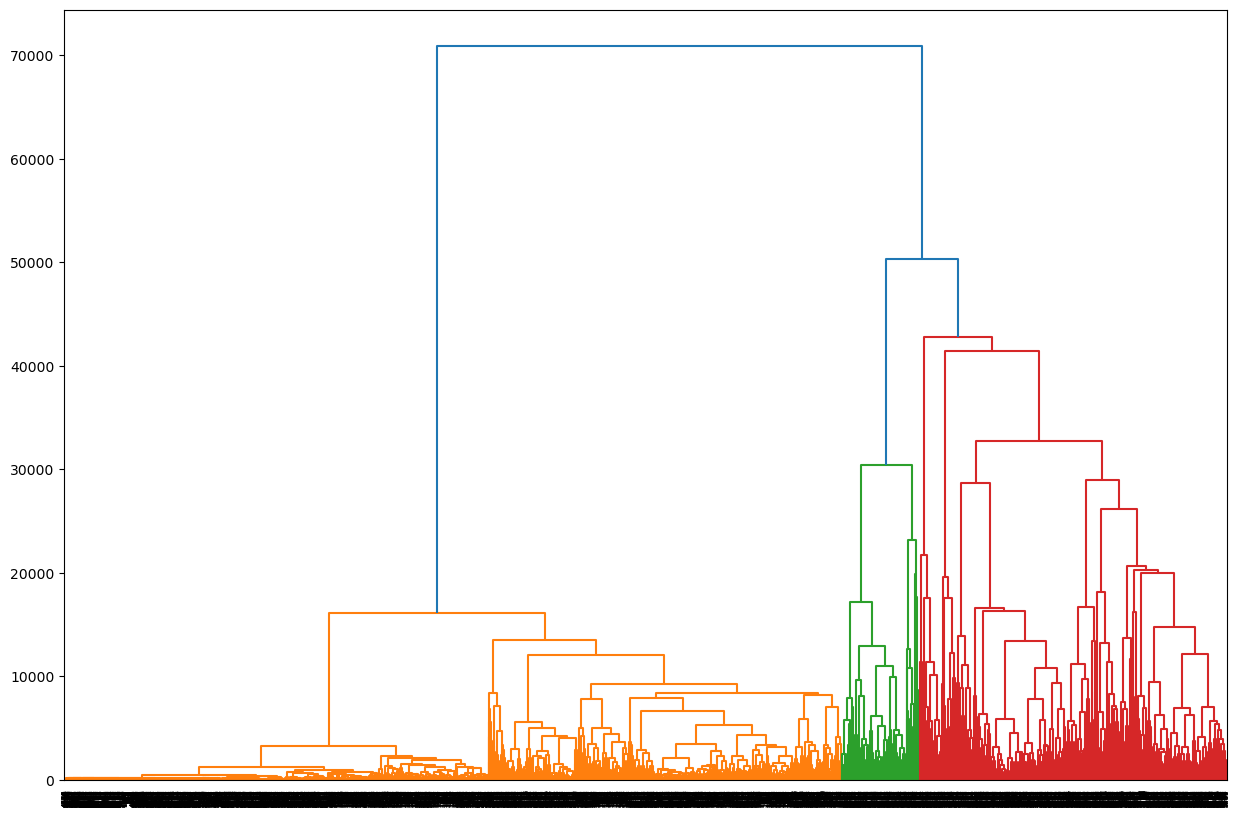

In [119]:
X = case_matrix
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(15, 10))
dn = dendrogram(Z)

In [41]:

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)

In [ ]:
X = case_matrix
nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
clusters = skc.AgglomerativeClustering(n_clusters=10).fit_predict(X)

In [ ]:
muni_ids = all_data.select(pl.col('muni_id')).unique().sort('muni_id').to_series()

In [ ]:
muni_cluster_mapper = {m:c for m, c in zip(muni_ids, clusters)}

In [ ]:
clustered_data = all_data.with_columns(pl.col('muni_id').map_dict(muni_cluster_mapper).alias('cluster'))

In [ ]:
clustered_data
clustered_data.select(pl.first('count')).item()

In [ ]:
split_clusters = [clustered_data.filter(pl.col('cluster') == c).group_by(['start_date']).agg(pl.col('count').sum(), pl.col('cluster').first()) for c in np.unique(clusters)]

In [ ]:
split_clusters[0]

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize=(20,20))
for i, c in enumerate(split_clusters):
    ax[i].plot(c['start_date'], c['count'])
    ax[i].set_title(c.select(pl.first('cluster')).item())

In [19]:
index_muni_mapper = {m:i for m, i in enumerate(all_data.select('muni_id').unique().sort('muni_id').to_series())}
index_muni_mapper

{0: 110001,
 1: 110002,
 2: 110003,
 3: 110004,
 4: 110005,
 5: 110006,
 6: 110007,
 7: 110008,
 8: 110009,
 9: 110010,
 10: 110011,
 11: 110012,
 12: 110013,
 13: 110014,
 14: 110015,
 15: 110018,
 16: 110020,
 17: 110025,
 18: 110026,
 19: 110028,
 20: 110029,
 21: 110030,
 22: 110032,
 23: 110033,
 24: 110034,
 25: 110037,
 26: 110040,
 27: 110045,
 28: 110050,
 29: 110060,
 30: 110070,
 31: 110080,
 32: 110090,
 33: 110092,
 34: 110094,
 35: 110100,
 36: 110110,
 37: 110120,
 38: 110130,
 39: 110140,
 40: 110143,
 41: 110145,
 42: 110146,
 43: 110147,
 44: 110148,
 45: 110149,
 46: 110150,
 47: 110155,
 48: 110160,
 49: 110170,
 50: 110175,
 51: 110180,
 52: 120001,
 53: 120005,
 54: 120010,
 55: 120013,
 56: 120017,
 57: 120020,
 58: 120025,
 59: 120030,
 60: 120032,
 61: 120033,
 62: 120034,
 63: 120035,
 64: 120038,
 65: 120039,
 66: 120040,
 67: 120042,
 68: 120043,
 69: 120045,
 70: 120050,
 71: 120060,
 72: 120070,
 73: 120080,
 74: 130002,
 75: 130006,
 76: 130008,
 77: 1300

In [ ]:
connections = pl.DataFrame({
    'muni_id': all_data.select('muni_id').unique().sort('muni_id').to_series(),
    'indices': indices,
    'distances': distances
}).with_columns(pl.col('indices').list.eval(pl.element().map_dict(index_muni_mapper)).alias('muni_neighbors'))

In [ ]:
def select_muni_and_neighbors(muni_id, data_df, connections_df) -> pl.DataFrame: 
    return (
        data_df
        .filter(
            pl.col('muni_id')
            .is_in(connections_df
                   .filter(pl.col('muni_id') == muni_id)
                   .select('muni_neighbors')
                   .to_series()
                   .item()
                )
            )
    )

    

In [ ]:
def get_solo_training_target(df, muni_id, month_lag, predict_lag):
    lagged_df = (df
        .filter(pl.col('muni_id') == muni_id)
        .sort('end_date')
        .with_columns(
            case_lag = pl.col('cases_per_100k')
            .rolling(index_column='end_date', period=f'{month_lag}mo')
            .list
            .head(month_lag - predict_lag)
            )
        .filter(pl.col('case_lag').list.len() == month_lag-predict_lag)
        .select(['cases_per_100k', 'case_lag'])
    )
    target = lagged_df.select('cases_per_100k').to_series().to_numpy()
    train = np.vstack(lagged_df.select('case_lag').to_series())

    return train, target

In [ ]:
neighbor_list = (connections.filter(pl.col('muni_id') == 230835)
                   .select('muni_neighbors')
                   .to_series()
                   .item()
)
train_list = []
first_train, target = get_solo_training_target(all_data, neighbor_list[0], 24, 1)
train_list.append(first_train)
for neighbor in neighbor_list[1:]:
    to_add, _ = get_solo_training_target(all_data, neighbor, 23, 0)
    train_list.append(to_add)
X = np.concatenate(train_list, axis=1)
y = target

In [ ]:
X.shape

In [5]:
with open('/home/tony/dengue/dengue_models/calced_clusters.pkl', 'rb') as f:
        test = pickle.load(f)

In [6]:
top_dog = None
parent_rmse = []
no_parent_rmse = []
ids = []
deltas = []
for k, v in test.items():
    if 'no_parent_rmse' in v:
        parent_rmse.append(v['rmse'])
        no_parent_rmse.append(v['no_parent_rmse'])
        deltas.append(v['parent_rmse_delta'])
        ids.append(k)
        if v['no_parent_rmse'] > 25000:
            top_dog = v

In [22]:
parents = np.array(parent_rmse)
no_parents = np.array(no_parent_rmse)
id_arr = np.vectorize(index_muni_mapper.get)(np.array(ids))
delta = np.array(deltas)

results_df = pd.DataFrame({
    'muni_id': id_arr,
    'parents_rmse': parents,
    'no_parents_rmse': no_parents,
    'delta': delta
})

In [33]:
munis = munis.rename({'CD_MUN': 'muni_id'}, axis=1)

In [37]:
cluster_results = munis.merge(results_df, on='muni_id')

In [46]:
pops = all_data.filter((pl.col('year')=='2020')&(pl.col('month')==1)).select(['muni_id', 'pop']).to_pandas()

In [47]:
cluster_results = cluster_results.merge(pops, on='muni_id')

<Axes: title={'center': 'Accuracy change when using hierarchical model'}, ylabel='Frequency'>

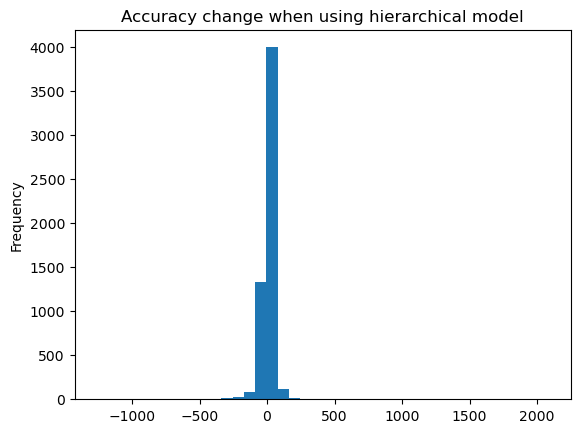

In [117]:
cluster_results['delta'][cluster_results['delta']<20000].plot(kind="hist", bins=40, title='Accuracy change when using hierarchical model')

<Axes: >

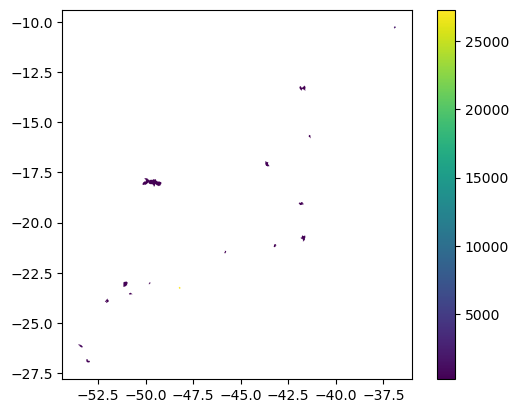

In [40]:
cluster_results[cluster_results['delta']>200].plot(column='delta', legend=True)

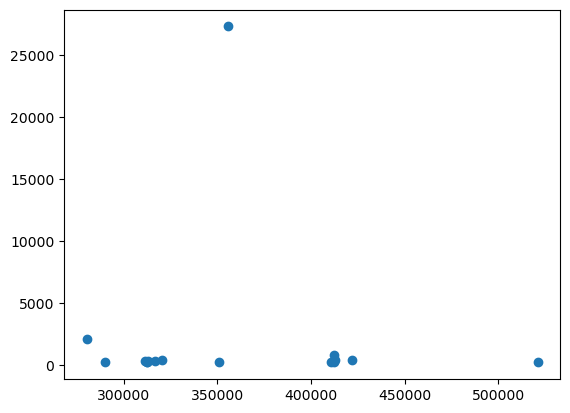

In [21]:
plt.scatter(id_arr[good_results], delta[good_results])

In [134]:
subfolders = [ f.path for f in os.scandir('/home/tony/dengue/dengue_models/results') if f.is_dir() ]

In [135]:
cat_results = {}
for f in subfolders:
    results = pl.read_csv(f'{f}/*.csv').filter(pl.col('error')=='NONE')
    name = f.split('/')[-1]
    cat_results[name] = results

In [136]:
from sklearn.metrics import classification_report, confusion_matrix
cat_metrics = {}

for k,v in cat_results.items():
    cat_metrics[k] = {
        'report': classification_report(v.select('ground_truth'), v.select('predictions')),
        'conf_matrix': confusion_matrix(v.select('ground_truth'), v.select('predictions'))
    }

In [140]:
print(cat_metrics['relative_binary_global']['report'])

              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84     98590
         1.0       0.52      0.76      0.62     30242

    accuracy                           0.78    128832
   macro avg       0.72      0.77      0.73    128832
weighted avg       0.82      0.78      0.79    128832



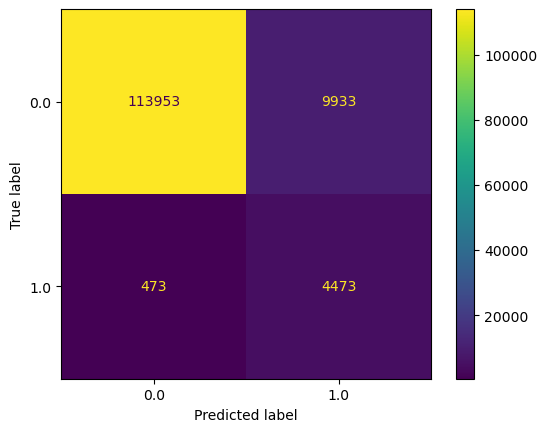

In [142]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(cat_results['simple_binary_global'].select('ground_truth'),
                                        cat_results['simple_binary_global'].select('predictions'),
                                        #normalize=''
                                        )

In [143]:
pl.read_parquet('/home/tony/dengue/dengue_models/results/temp_test/simple_ternary_all_results.parquet')

predictions,ground_truth,date,muni_id,cat_style,error,probabilities
f64,f64,date,i64,str,str,list[f64]
0.0,0.0,2018-01-01,261090,"""simple_ternary…","""NONE""","[0.809794, 0.172788, 0.017418]"
0.0,0.0,2018-02-01,261090,"""simple_ternary…","""NONE""","[0.748464, 0.213766, 0.037771]"
0.0,0.0,2018-03-01,261090,"""simple_ternary…","""NONE""","[0.602855, 0.340521, 0.056624]"
0.0,0.0,2018-04-01,261090,"""simple_ternary…","""NONE""","[0.851771, 0.128152, 0.020077]"
0.0,0.0,2018-05-01,261090,"""simple_ternary…","""NONE""","[0.919667, 0.06591, 0.014424]"
0.0,0.0,2018-06-01,261090,"""simple_ternary…","""NONE""","[0.973479, 0.021253, 0.005269]"
0.0,0.0,2018-07-01,261090,"""simple_ternary…","""NONE""","[0.983635, 0.0131, 0.003265]"
0.0,0.0,2018-08-01,261090,"""simple_ternary…","""NONE""","[0.989233, 0.008858, 0.001909]"
0.0,0.0,2018-09-01,261090,"""simple_ternary…","""NONE""","[0.992364, 0.006436, 0.0012]"


In [4]:
all_cases = pl.read_parquet('/home/tony/dengue/dengue_models/data/cases/agged/all_dengue_cases.parquet').rename({
                'DT_NOTIFIC': 'start_date',
                'ID_MUNICIP': 'muni_id'
        })

In [16]:
test = (all_cases
            .sort('start_date')
            .group_by_dynamic('start_date' , every='1d', 
                              period='1mo_saturating',
                                by='muni_id').agg([
                pl.count(),
                pl.first('x_centroid'),
                pl.first('y_centroid'),
                pl.first('NM_MUN'),
                pl.first('pop'),
                pl.first('year')
            ])
            .with_columns(
                (pl.col('count')/(pl.col('pop')/100000)).alias('cases_per_100k'))
)
test

muni_id,start_date,count,x_centroid,y_centroid,NM_MUN,pop,year,cases_per_100k
str,date,u32,f64,f64,str,i64,str,f64
"""240810""",2000-12-31,1071,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",148.308371
"""240810""",2001-01-01,1121,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",155.232197
"""240810""",2001-01-02,1166,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",161.463642
"""240810""",2001-01-03,1226,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",169.772234
"""240810""",2001-01-04,1248,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",172.818718
"""240810""",2001-01-05,1246,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",172.541765
"""240810""",2001-01-06,1330,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",184.173794
"""240810""",2001-01-07,1361,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",188.466566
"""240810""",2001-01-08,1418,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",196.359729


In [17]:
upped = (test.sort('start_date').upsample(
    time_column='start_date', every='1d', by='muni_id', maintain_order=True
).with_columns(pl.exclude(['count', 'cases_per_100k']).forward_fill())

)

upped

start_date,muni_id,count,x_centroid,y_centroid,NM_MUN,pop,year,cases_per_100k
date,str,u32,f64,f64,str,i64,str,f64
2000-12-31,"""240810""",1071,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",148.308371
2001-01-01,"""240810""",1121,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",155.232197
2001-01-02,"""240810""",1166,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",161.463642
2001-01-03,"""240810""",1226,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",169.772234
2001-01-04,"""240810""",1248,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",172.818718
2001-01-05,"""240810""",1246,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",172.541765
2001-01-06,"""240810""",1330,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",184.173794
2001-01-07,"""240810""",1361,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",188.466566
2001-01-08,"""240810""",1418,7.0786e6,9.3239e6,"""Natal""",722144,"""2001""",196.359729


In [18]:
upped.write_parquet('/home/tony/dengue/dengue_models/data/cases/agged/dengue_monthly_super_sampled.parquet')

: 